## Machine Failure Prediction

## Data Understanding

In [191]:
## load dataset
import pandas as pd
import re
path = r"https://raw.githubusercontent.com/Vrb77/Datasets/refs/heads/main/classification-train-dataset.csv"
df=pd.read_csv(path)
# Clean column names
df.columns = [re.sub(r'[\s\[\]]+', '_', col).strip('_') for col in df.columns]
df.head()

,id,Product_ID,Type,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Machine_failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [192]:
df.shape

(136429, 14)

In [193]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     136429 non-null  int64  
 1   Product_ID             136429 non-null  str    
 2   Type                   136429 non-null  str    
 3   Air_temperature_K      136429 non-null  float64
 4   Process_temperature_K  136429 non-null  float64
 5   Rotational_speed_rpm   136429 non-null  int64  
 6   Torque_Nm              136429 non-null  float64
 7   Tool_wear_min          136429 non-null  int64  
 8   Machine_failure        136429 non-null  int64  
 9   TWF                    136429 non-null  int64  
 10  HDF                    136429 non-null  int64  
 11  PWF                    136429 non-null  int64  
 12  OSF                    136429 non-null  int64  
 13  RNF                    136429 non-null  int64  
dtypes: float64(3), int64(9), str(2)
memory usage: 1

In [194]:
# check for duplicated rows
df.duplicated().sum()

np.int64(0)

In [195]:
df=df.drop_duplicates()

In [196]:
df.isna().sum()

id                       0
Product_ID               0
Type                     0
Air_temperature_K        0
Process_temperature_K    0
Rotational_speed_rpm     0
Torque_Nm                0
Tool_wear_min            0
Machine_failure          0
TWF                      0
HDF                      0
PWF                      0
OSF                      0
RNF                      0
dtype: int64

In [197]:
df['Machine_failure'].value_counts()

Machine_failure
0    134281
1      2148
Name: count, dtype: int64

**As we see above the dataset is imbalanced**

**Machine failure(1) < Machine Not Failure(0)**

## Saparate feature(X) and Target(Y) columns

In [198]:
X = df.drop(columns=['id','Product_ID','Machine_failure'])
Y = df[['Machine_failure']]

## Data Cleaning and Data Preprocessing

In [199]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

binary_cols = ['TWF','HDF','PWF','OSF','RNF']  # explicitly name it
cat =list(X.select_dtypes(include='str').columns)
con = [c for c in X.select_dtypes(include='number').columns 
       if c not in binary_cols]
print(con)

# # Identify binary columns (only 0 and 1)
# binary = [col for col in con if X[col].dropna().isin([0, 1]).all()]
# con = [col for col in con if col not in binary]  # remove binary from numeric

num_pipe= make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

cat_pipe=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore',sparse_output=False)
)

pre=ColumnTransformer([
    ('cat',cat_pipe,cat),
    ('con',num_pipe,con),
    ('binary', 'passthrough', binary_cols)  # keeps 0/1 as-is
]).set_output(transform='pandas')

X_pre=pre.fit_transform(X)
X_pre.head()

['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min']


,cat__Type_H,cat__Type_L,cat__Type_M,con__Air_temperature_K,con__Process_temperature_K,con__Rotational_speed_rpm,con__Torque_Nm,con__Tool_wear_min,binary__TWF,binary__HDF,binary__PWF,binary__OSF,binary__RNF
0,0.0,1.0,0.0,0.395880,-0.246230,0.545416,-0.499711,0.556417,0,0,0,0,0
1,0.0,0.0,1.0,1.469856,1.558605,1.720308,-1.323028,1.494433,0,0,0,0,0
2,0.0,1.0,0.0,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,0,0,0,0,0
3,0.0,1.0,0.0,0.610675,0.692284,0.026445,0.464745,1.447532,0,0,0,0,0
4,0.0,0.0,1.0,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,0,0,0,0,0


## Separate the data into training and testing

In [200]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(X_pre,Y,train_size=0.66,stratify=Y,random_state=21)
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(90043, 13)
(46386, 13)
(90043, 1)
(46386, 1)


## Handle Imbalanced data
## ADASYN : Increasing the samples of minority class

In [201]:
ytrain['Machine_failure'].value_counts()

Machine_failure
0    88625
1     1418
Name: count, dtype: int64

In [202]:
from imblearn.over_sampling import ADASYN
ada= ADASYN()
x_sampl,y_sampl = ada.fit_resample(xtrain,ytrain)

In [203]:
y_sampl.value_counts()

Machine_failure
0                  88625
1                  88554
Name: count, dtype: int64

**Imbalanced data is handled by increasing the samples**

## Exploratory Data Analysis (EDA)

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
wr.filterwarnings('ignore')

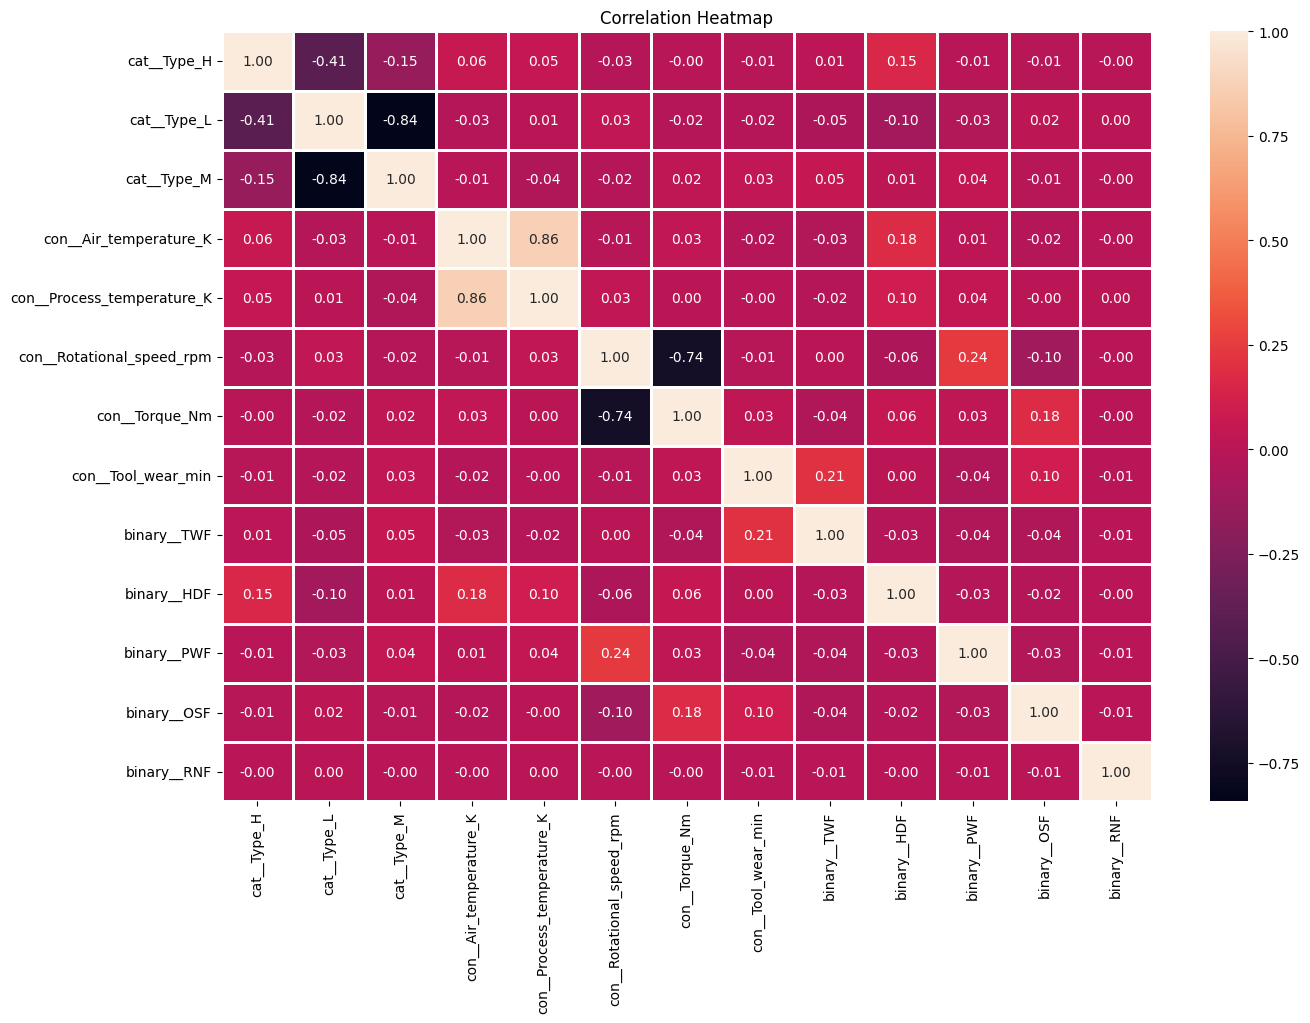

In [205]:
plt.figure(figsize=(15, 10))
sns.heatmap(x_sampl.corr(), annot=True, fmt='.2f', linewidths=2)
plt.title('Correlation Heatmap')
plt.show()

Strong Positive correlation
1) Process temperature [K] and Air temperature [K]

Strong Negative Correlation
1) Torque[NM] and Rotational speed[rpm]

## Handle Multicollinearity

In [206]:
# import numpy as np

# # Step 1: Get correlation matrix
# corr_matrix = x_sampl.corr().abs()  # abs() covers negative correlation too

# # Step 2: Find highly correlated pairs
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# # Step 3: Drop columns with correlation > 0.9
# to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
# print("Dropping:", to_drop)

# # Step 4: Drop them
# x_sampl = x_sampl.drop(columns=to_drop)
# x_sampl

<Axes: ylabel='Machine_failure'>

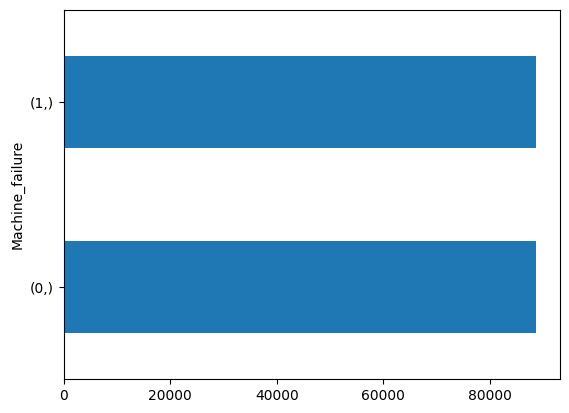

In [207]:
y_sampl.value_counts().plot(kind='barh')

## Model Building

## Model 1: Logistic Regression

In [208]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression(class_weight='balanced') # imbalanced scenario
# class_weight='balanced' will add penalty to the minority classes.
model1.fit(x_sampl,y_sampl)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [209]:
model1.score(x_sampl,y_sampl)

0.7431185411363649

In [210]:
model1.score(xtest,ytest)

0.8271676799034191

In [211]:
from sklearn.metrics import classification_report
import numpy as np
ypreds_base = model1.predict(xtest)
print(classification_report(ytest,ypreds_base))

              precision    recall  f1-score   support

           0       1.00      0.83      0.90     45656
           1       0.08      0.90      0.14       730

    accuracy                           0.83     46386
   macro avg       0.54      0.86      0.52     46386
weighted avg       0.98      0.83      0.89     46386



## Model 2: Decision Tree Classifier

In [212]:
from sklearn.tree import DecisionTreeRegressor

model2 = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=3,
    min_samples_split=8,
    criterion='squared_error'
)

model2.fit(x_sampl,y_sampl)

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",8
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",3
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_le

In [213]:
model2.score(x_sampl,y_sampl)

0.3831052382729746

In [214]:
model2.score(xtest,ytest)

-7.480452508522189

In [215]:
# from sklearn.metrics import classification_report
# import numpy as np
# ypreds_base = model2.predict(xtest)
# print(classification_report(ytest,ypreds_base))

## Model 3: Random Forest Classifier

In [216]:
from sklearn.ensemble import RandomForestClassifier

model3 = RandomForestClassifier(
    n_estimators=100,
    max_depth=10
)
model3.fit(x_sampl,y_sampl)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [217]:
model3.score(x_sampl,y_sampl)

0.8611460726158292

In [218]:
model3.score(xtest,ytest)

0.9040227654895874

In [219]:
from sklearn.metrics import classification_report
import numpy as np
ypreds_base = model3.predict(xtest)
print(classification_report(ytest,ypreds_base))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     45656
           1       0.13      0.90      0.23       730

    accuracy                           0.90     46386
   macro avg       0.56      0.90      0.59     46386
weighted avg       0.98      0.90      0.94     46386



In [220]:
# from sklearn.svm import SVC # support vector classifier
# model = SVC()
# model.fit(xtrain,ytrain)

## As Random Forest Classifier have high score in training as well as testing. This model will perform well

## Evaluation of the model

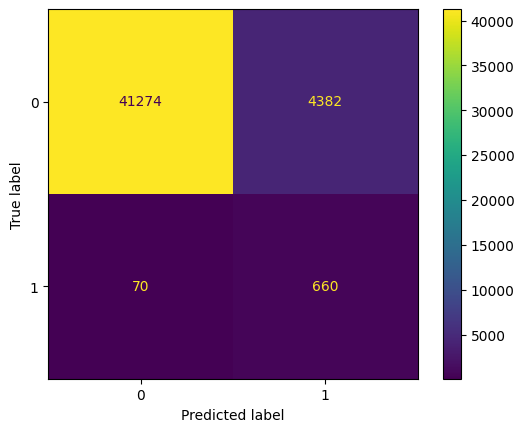

In [221]:
ypreds = model3.predict(xtest)
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
ConfusionMatrixDisplay.from_estimator(model3,xtest,ytest)

**Classification Report**

In [222]:
ypreds_rnd = model3.predict(xtest)
print(classification_report(ytest,ypreds_rnd))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     45656
           1       0.13      0.90      0.23       730

    accuracy                           0.90     46386
   macro avg       0.56      0.90      0.59     46386
weighted avg       0.98      0.90      0.94     46386



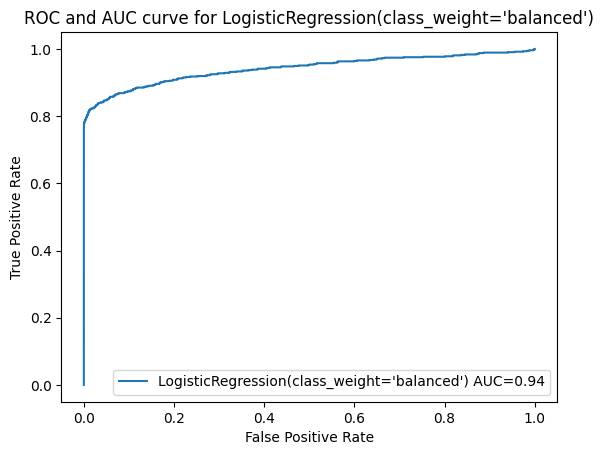

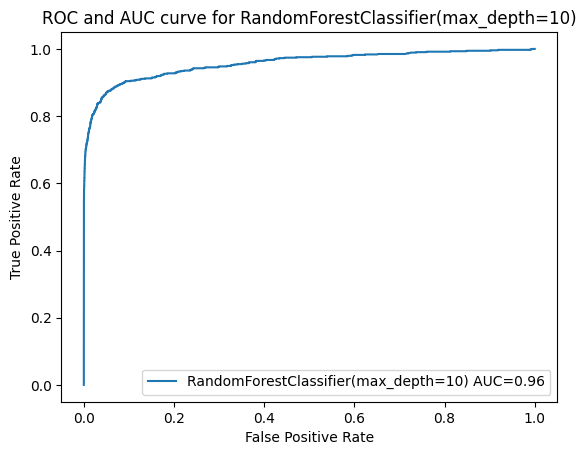

In [223]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
# create a list of all the models
models = [model1,model3]
auc_scores = []

for model in models:
    y_pred_proba =model.predict_proba(xtest)[:,1] #get probability for the positive class
    fpr,tpr,thresholds = roc_curve(ytest,y_pred_proba )
    roc_auc_score = auc(fpr,tpr) #Main auc score for each model
    auc_scores.append(roc_auc_score)
    plt.plot (fpr,tpr,label=f'{model} AUC={roc_auc_score:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC and AUC curve for {model}')
    plt.legend()
    plt.show()

**Random Forest Classifier have higher accuracy**

## Check on unseen data

In [224]:
# pip install joblib
import joblib

# save the pipeline - data cleaning and data preprocessing
joblib.dump(pre,'machine_failure_pre.joblib')

# save the model (best ridge)
joblib.dump(model2,'machine_failure_model.joblib')

['machine_failure_model.joblib']

In [225]:
model3_load = joblib.load('machine_failure_model.joblib')
pre_load = joblib.load('machine_failure_pre.joblib')

In [226]:
path2 = r'https://raw.githubusercontent.com/Vrb77/Datasets/refs/heads/main/classification-test-out%20of%20sample%20predictions.csv'
xnew = pd.read_csv(path2)
xnew

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90949,227378,L51130,L,302.3,311.4,1484,40.4,15,0,0,0,0,0
90950,227379,L47783,L,297.9,309.8,1542,33.8,31,0,0,0,0,0
90951,227380,L48097,L,295.6,306.2,1501,41.4,187,0,0,0,0,0
90952,227381,L48969,L,298.1,307.8,1534,40.3,69,0,0,0,0,0


In [227]:
xnew.columns = [re.sub(r'[\s\[\]]+', '_', col).strip('_') for col in xnew.columns]
xnew_pre = pre_load.transform(xnew)
xnew_pre

,cat__Type_H,cat__Type_L,cat__Type_M,con__Air_temperature_K,con__Process_temperature_K,con__Rotational_speed_rpm,con__Torque_Nm,con__Tool_wear_min,binary__TWF,binary__HDF,binary__PWF,binary__OSF,binary__RNF
0,0.0,1.0,0.0,1.308759,1.125444,-0.153753,-0.276240,-0.694271,0,0,0,0,0
1,0.0,1.0,0.0,0.986567,0.764477,1.388744,-1.358313,-1.366516,0,0,0,0,0
2,0.0,1.0,0.0,0.771772,0.331317,0.033653,-0.311525,-0.131461,0,0,0,0,0
3,0.0,0.0,1.0,0.127386,-0.246230,-0.297912,0.852880,-1.554119,0,0,0,0,0
4,0.0,0.0,1.0,1.899446,1.702992,-0.038426,0.111895,0.149943,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90949,0.0,1.0,0.0,1.308759,1.053251,-0.261872,0.006040,-1.397783,0,0,0,0,0
90950,0.0,1.0,0.0,-1.053986,-0.101844,0.156188,-0.770229,-1.147645,0,0,0,0,0
90951,0.0,1.0,0.0,-2.289058,-2.700806,-0.139337,0.123657,1.291196,0,0,0,0,0
90952,0.0,1.0,0.0,-0.946589,-1.545712,0.098524,-0.005721,-0.553568,0,0,0,0,0


In [228]:
preds = model3.predict(xnew_pre)
preds

array([0, 0, 0, ..., 0, 0, 0], shape=(90954,))

In [229]:
# Save the results to csv file
xnew.to_csv('Machine_failure_predictions.csv',index=False)